In [1]:
import pandas as pd
import numpy as np
from tabata.opset import Opset
from sklearn.cluster import KMeans
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Charger les données
input_file = "../Data/normalized/AFL1EB_normalized.h5"
ds = Opset(input_file)

reference = ds[11]
target = ds[44]

In [2]:
ds[44]

,ALT[m],Tisa[K],TAS[m/s],Vz[m/s],Masse[kg],F[N]
record_49,,,,,,
2013-02-19 13:25:00,0.001393,830.214351,0.0,-6.436615e-02,15942.336089,0.0
2013-02-19 13:25:01,0.001393,830.214351,0.0,-6.354071e-02,15942.336089,0.0
2013-02-19 13:25:02,0.001393,830.214351,0.0,-6.271527e-02,15942.336089,0.0
2013-02-19 13:25:03,0.001509,830.191528,0.0,-6.188984e-02,15942.336089,0.0
2013-02-19 13:25:04,0.001509,830.191528,0.0,-6.106440e-02,15942.336089,0.0
...,...,...,...,...,...,...
2013-02-19 16:36:17,0.002437,830.008941,0.0,8.292566e-16,13858.394190,0.0
2013-02-19 16:36:18,0.002437,830.008941,0.0,8.545729e-16,13858.394190,0.0
2013-02-19 16:36:19,0.002437,830.008941,0.0,8.798892e-16,13858.394190,0.0


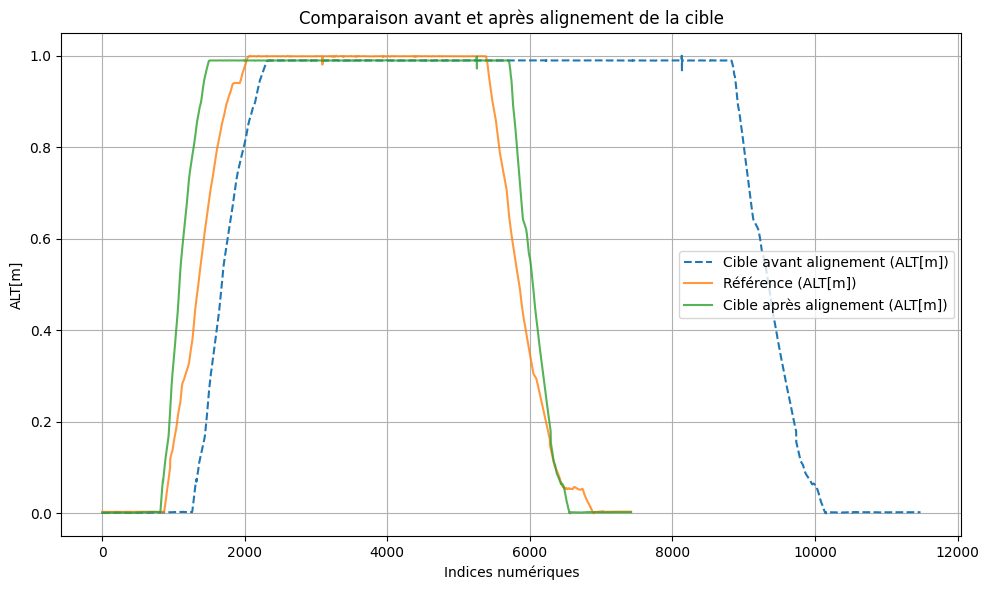

In [3]:
import matplotlib.pyplot as plt

ref_indices = np.linspace(0, 1, len(reference))
tgt_indices = np.linspace(0, 1, len(target))

# Interpolation des données de 'target' pour correspondre à 'reference'
interpolated_target = pd.DataFrame({
    col: np.interp(ref_indices, tgt_indices, target[col])
    for col in target.columns
}, index=reference.index)

plt.figure(figsize=(10, 6))
plt.plot(range(len(target)), target["ALT[m]"], label="Cible avant alignement (ALT[m])", linestyle='--')
plt.plot(range(len(reference)), reference["ALT[m]"], label="Référence (ALT[m])", alpha=0.8)
plt.plot(range(len(reference)), interpolated_target["ALT[m]"], label="Cible après alignement (ALT[m])", alpha=0.8)
plt.legend()
plt.xlabel("t(sec)")
plt.ylabel("ALT[m]")
plt.title("Comparaison avant et après alignement de la cible")
plt.grid()
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import pandas as pd
from scipy.ndimage import gaussian_filter1d

# Charger les données
input_file = "../Data/normalized/AFL1EB_normalized.h5"
from tabata.opset import Opset
ds = Opset(input_file)
target = ds[11]

# Sous-échantillonnage régulier (10% des données)
subset_fraction = 0.1
target = target.iloc[::int(1 / subset_fraction), :]

# Préparer les observations
alt = target["ALT[m]"].values
vz = target["Vz[m/s]"].values
tas = target["TAS[m/s]"].values

# Filtrage pour réduire le bruit
alt = gaussian_filter1d(alt, sigma=2)
vz = gaussian_filter1d(vz, sigma=2)
tas = gaussian_filter1d(tas, sigma=2)

# Normaliser les données
observations = np.column_stack([alt, vz, tas])

# Définir les phases (états cachés) avec un ordre logique
states = ["Sol", "Décollage", "Montée", "Croisière", "Descente", "Atterrissage"]
n_states = len(states)

# Définir une matrice de transition contrainte (semi-supervisée)
transition_matrix = np.zeros((n_states, n_states))

# Remplir les probabilités possibles (ordre logique des phases)
for i in range(n_states - 1):
    transition_matrix[i, i] = 0.7  # Rester dans la même phase (auto-transition)
    transition_matrix[i, i + 1] = 0.3  # Transition vers la phase suivante

# Dernière phase (atterrissage) reste stable
transition_matrix[-1, -1] = 1.0
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

# Initialiser le modèle HMM avec la matrice de transition contrainte
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="diag",
    n_iter=1000,
    tol=1e-4,
    init_params="mcs",
    random_state=42,
)

# Intégrer la matrice de transition contrainte
model.transmat_ = transition_matrix

# Entraîner le modèle sur les observations
model.fit(observations)

# Décoder les états avec l'algorithme de Viterbi
hidden_states = model.predict(observations)

# Ajouter les phases détectées dans le DataFrame
target["Phase"] = [states[state] for state in hidden_states]

# Tracer les résultats
plt.figure(figsize=(12, 6))

# L'axe des x correspond aux indices des observations (1 à len(df))
x_indices = np.arange(1, len(target) + 1)

plt.plot(x_indices, alt, label="Altitude (normalisée)", alpha=0.7, color="blue")

# Tracer les phases détectées
for i, state in enumerate(states):
    plt.scatter(
        x_indices[hidden_states == i],
        alt[hidden_states == i],
        label=state,
        s=10,
    )

plt.xlabel("Index des observations")
plt.ylabel("Altitude (normalisée)")
plt.title("Phases de vol détectées avec HMM (ordre contraint)")
plt.legend()
plt.grid()
plt.show()


c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning:

invalid value encountered in divide

Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have ze

ValueError: startprob_ must sum to 1 (got nan)

In [5]:
target

,ALT[m],Tisa[K],TAS[m/s],Vz[m/s],Masse[kg],F[N],Phase
record_49,,,,,,,
2013-02-19 13:25:00,0.001393,830.214351,0.0,-6.436615e-02,15942.336089,0.0,Décollage
2013-02-19 13:25:10,0.001393,830.214351,0.0,-5.611178e-02,15942.336089,0.0,Décollage
2013-02-19 13:25:20,0.001277,830.237175,0.0,-4.785741e-02,15942.336089,0.0,Décollage
2013-02-19 13:25:30,0.001393,830.214351,0.0,-3.960305e-02,15942.336089,0.0,Décollage
2013-02-19 13:25:40,0.001277,830.237175,0.0,-1.711780e-02,15942.336089,0.0,Décollage
...,...,...,...,...,...,...,...
2013-02-19 16:35:40,0.002437,830.008941,0.0,6.582625e-14,13858.394190,0.0,Atterrissage
2013-02-19 16:35:50,0.002437,830.008941,0.0,6.582625e-14,13858.394190,0.0,Atterrissage
2013-02-19 16:36:00,0.002437,830.008941,0.0,3.988791e-16,13858.394190,0.0,Atterrissage


C:\Users\ruber\AppData\Local\Temp\ipykernel_1384\1691825109.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



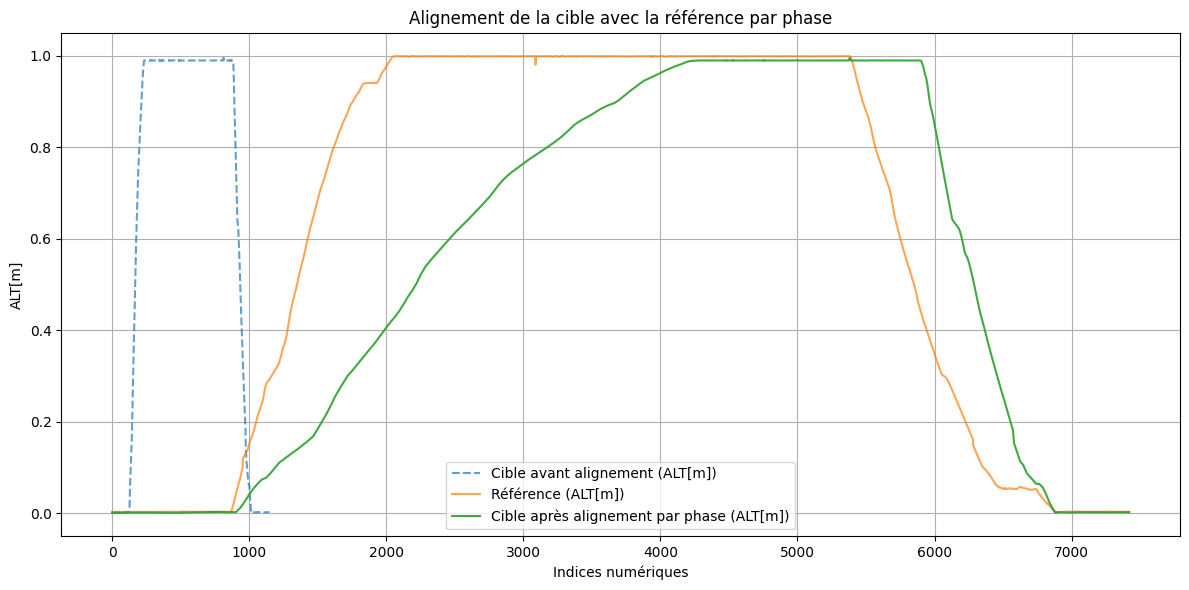

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Fonction pour détecter les phases avec HMM
def detect_phases(data, model, states):
    observations = np.column_stack([data["ALT[m]"], data["Vz[m/s]"], data["TAS[m/s]"]])
    hidden_states = model.predict(observations)
    data["Phase"] = [states[state] for state in hidden_states]
    return data

# Étape 1 : Détecter les phases pour le vol de référence et la cible
reference = detect_phases(reference, model, states)
target = detect_phases(target, model, states)

# Étape 2 : Aligner par phase
aligned_data = []

for phase in states:
    # Extraire les données de la phase actuelle pour référence et cible
    ref_phase = reference[reference["Phase"] == phase]
    tgt_phase = target[target["Phase"] == phase]
    
    if len(ref_phase) > 1 and len(tgt_phase) > 1:
        # Normaliser les indices
        ref_indices = np.linspace(0, 1, len(ref_phase))
        tgt_indices = np.linspace(0, 1, len(tgt_phase))
        
        # Interpoler les données de la cible pour correspondre à la référence
        interpolated_phase = pd.DataFrame({
            col: np.interp(ref_indices, tgt_indices, tgt_phase[col])
            for col in tgt_phase.columns if col != "Phase"
        }, index=ref_phase.index)
        
        # Ajouter la phase interpolée
        interpolated_phase["Phase"] = phase
        aligned_data.append(interpolated_phase)

# Étape 3 : Combiner les données alignées
aligned_data = pd.concat(aligned_data).sort_index()

# Étape 4 : Visualisation des résultats
plt.figure(figsize=(12, 6))

# Tracer la colonne ALT[m] pour la cible avant alignement avec ses indices numériques
plt.plot(range(len(target)), target["ALT[m]"], label="Cible avant alignement (ALT[m])", linestyle='--', alpha=0.7)

# Tracer la colonne ALT[m] pour la référence avec ses indices numériques
plt.plot(range(len(reference)), reference["ALT[m]"], label="Référence (ALT[m])", alpha=0.7)

# Tracer la colonne ALT[m] pour la cible après alignement avec les indices numériques de la référence
plt.plot(range(len(aligned_data)), aligned_data["ALT[m]"], label="Cible après alignement par phase (ALT[m])", alpha=0.9)

# Ajuster les légendes et les axes
plt.legend()
plt.xlabel("Indices numériques")
plt.ylabel("ALT[m]")
plt.title("Alignement de la cible avec la référence par phase")
plt.grid()
plt.tight_layout()
plt.show()


Model is not converging.  Current: -4800.616785826133 is not greater than -4800.6165421370715. Delta is -0.00024368906179006444


372


C:\Users\ruber\AppData\Local\Temp\ipykernel_1384\1525274976.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



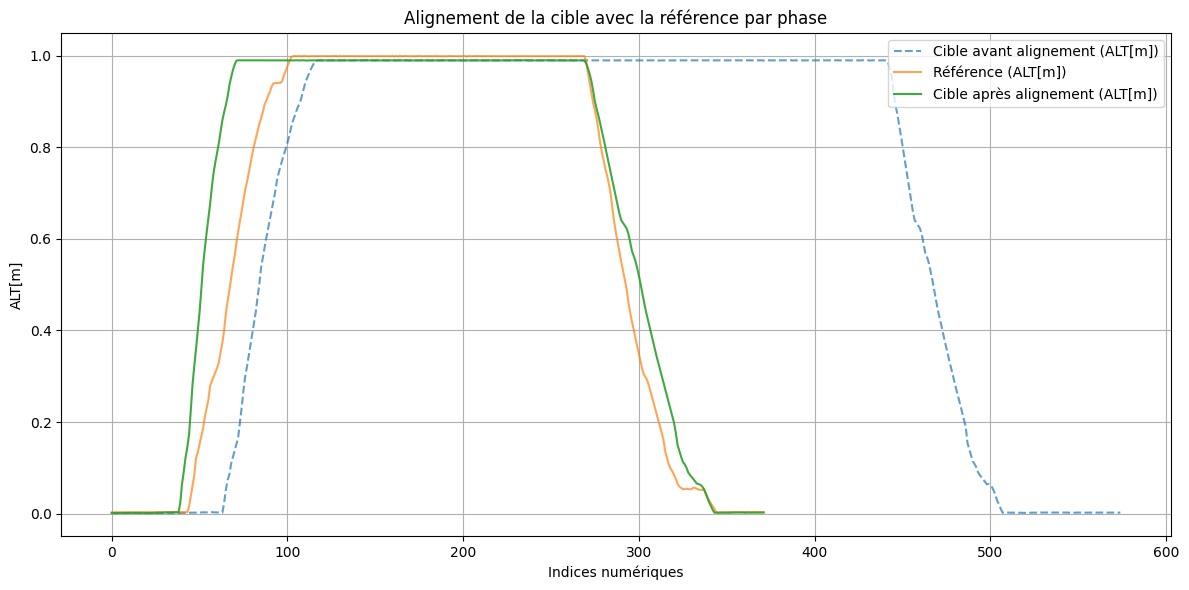

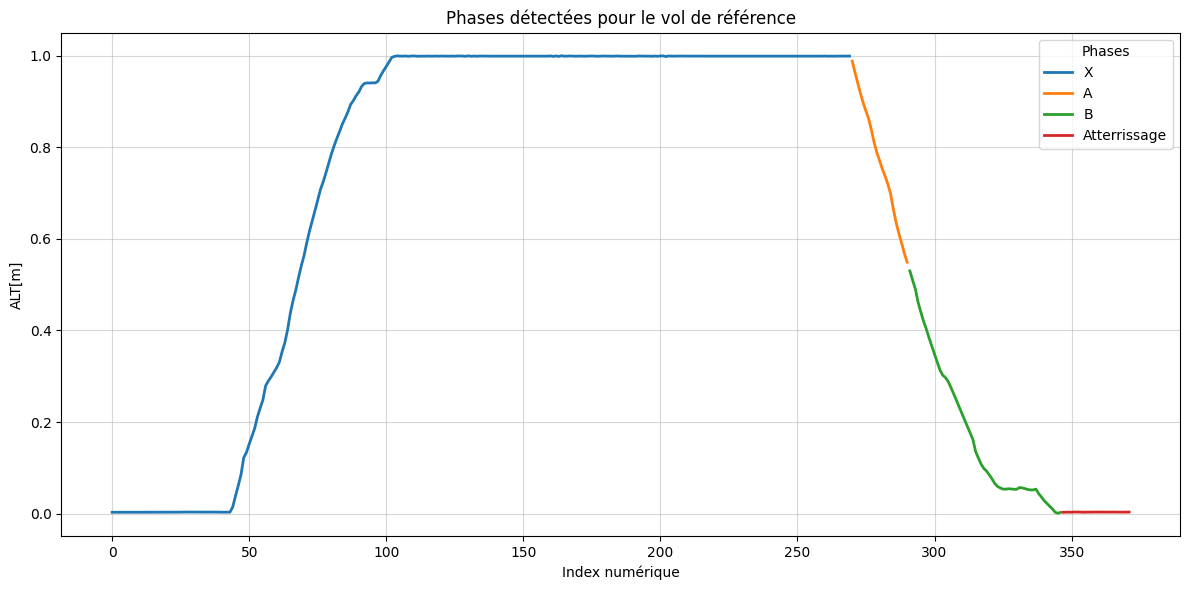

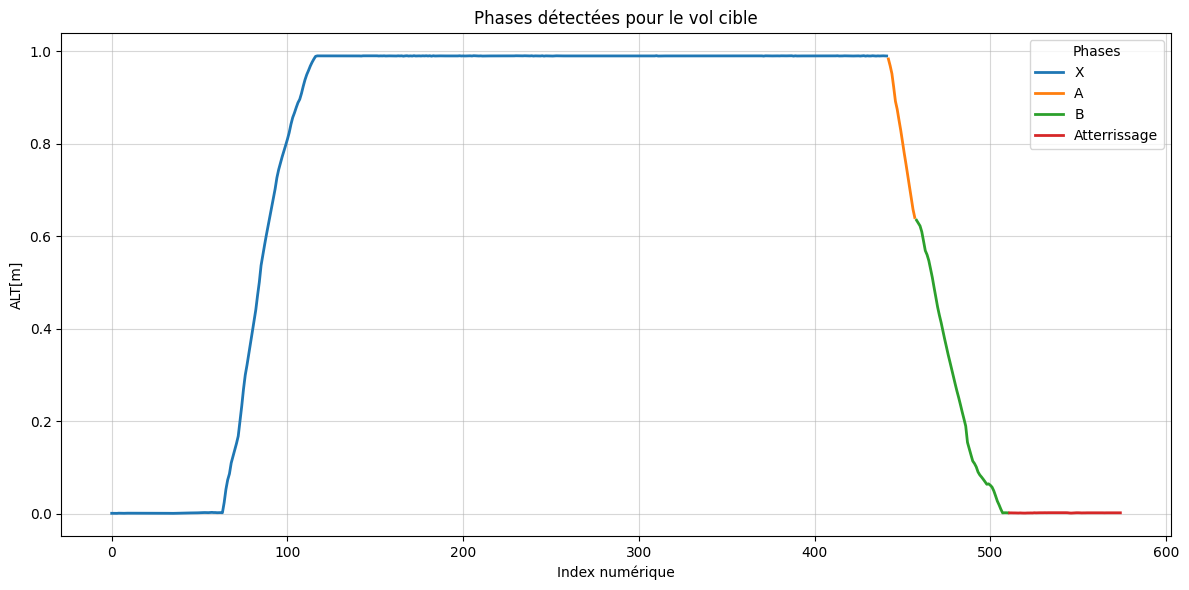

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from scipy.ndimage import gaussian_filter1d

# Fonction 1 : Prétraiter les données
def preprocess_data(data, subset_fraction=0.05, sigma=2):
    """
    Prétraite les données : sous-échantillonnage, filtrage gaussien et extraction des colonnes.
    """
    # Sous-échantillonnage
    data = data.iloc[::int(1 / subset_fraction), :]

    # Filtrage gaussien pour réduire le bruit
    alt = gaussian_filter1d(data["ALT[m]"].values, sigma=sigma)
    vz = gaussian_filter1d(data["Vz[m/s]"].values, sigma=sigma)
    tas = gaussian_filter1d(data["TAS[m/s]"].values, sigma=sigma)
    tisa = gaussian_filter1d(data["Tisa[K]"].values, sigma=sigma)
    f = gaussian_filter1d(data['F[N]'].values, sigma=sigma)


    # Retourner les observations sous forme de tableau
    observations = np.column_stack([alt, vz, tas])
    return data, observations

# Fonction 2 : Créer et entraîner un modèle HMM
def create_hmm_model(n_states, random_state=42):
    """
    Crée un modèle HMM avec une matrice de transition contrainte.
    """
    model = GaussianHMM(
        n_components=n_states,
        covariance_type="diag",
        n_iter=1000,
        tol=1e-4,
        init_params="mcs",
        random_state=random_state,
    )

    # Matrice de transition contrainte
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states - 1):
        transition_matrix[i, i] = 0.6  # Rester dans la même phase
        transition_matrix[i, i + 1] = 0.4  # Passer à la phase suivante
    transition_matrix[-1, -1] = 1.0  # Phase finale : rester dans "Atterrissage"

    model.transmat_ = transition_matrix
    return model

# Fonction 3 : Détecter les phases avec le HMM
def detect_phases(data, model, states):
    """
    Associe les phases détectées par le modèle HMM aux données.
    """
    observations = np.column_stack([
        data["ALT[m]"], 
        data["Vz[m/s]"], 
        data["TAS[m/s]"], 
    ])
    hidden_states = model.predict(observations)
    data["Phase"] = [states[state] for state in hidden_states]
    return data

# Fonction 4 : Aligner les données par phase
def align_by_phase(reference, target, states):
    """
    Aligne les données de la cible sur celles de la référence phase par phase.
    """
    aligned_data = []
    for phase in states:
        # Extraire les données de la phase courante
        ref_phase = reference[reference["Phase"] == phase]
        tgt_phase = target[target["Phase"] == phase]

        if len(ref_phase) > 1 and len(tgt_phase) > 1:
            # Normaliser les indices
            ref_indices = np.linspace(0, 1, len(ref_phase))
            tgt_indices = np.linspace(0, 1, len(tgt_phase))

            # Interpoler les données de la cible pour correspondre à la référence
            interpolated_phase = pd.DataFrame({
                col: np.interp(ref_indices, tgt_indices, tgt_phase[col])
                for col in tgt_phase.columns if col != "Phase"
            }, index=ref_phase.index)

            # Ajouter la phase interpolée
            interpolated_phase["Phase"] = phase
            aligned_data.append(interpolated_phase)

    # Combiner toutes les phases alignées
    return pd.concat(aligned_data).sort_index()

# Fonction 5 : Visualiser les résultats
def plot_alignment(reference, target, aligned_data):
    """
    Trace les données de la référence, de la cible et de la cible alignée.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(target)), target["ALT[m]"], label="Cible avant alignement (ALT[m])", linestyle='--', alpha=0.7)
    plt.plot(range(len(reference)), reference["ALT[m]"], label="Référence (ALT[m])", alpha=0.7)
    plt.plot(range(len(aligned_data)), aligned_data["ALT[m]"], label="Cible après alignement (ALT[m])", alpha=0.9)
    plt.legend()
    plt.xlabel("Indices numériques")
    plt.ylabel("ALT[m]")
    plt.title("Alignement de la cible avec la référence par phase")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Charger les données
input_file = "../Data/normalized/AFL1EB_normalized.h5"
from tabata.opset import Opset
ds = Opset(input_file)

# Charger les vols de référence et cible
reference = ds[11]  # Exemple : vol de référence
target = ds[44]    # Exemple : vol cible

# Prétraiter les données
reference, ref_obs = preprocess_data(reference)
target, tgt_obs = preprocess_data(target)
print(len(reference))
# Définir les phases et le modèle HMM
#states = ["Sol", "Décollage", "Montée", "Croisière", "Descente", "Atterrissage"]
states = ["X","A","B","Atterrissage"]
model = create_hmm_model(n_states=len(states))

# Entraîner le modèle sur le vol cible (ou sur des données combinées si nécessaire)
model.fit(tgt_obs)

# Détecter les phases pour la référence et la cible
reference = detect_phases(reference, model, states)
target = detect_phases(target, model, states)

# Aligner les données par phase
aligned_data = align_by_phase(reference, target, states)

# Visualiser les résultats
plot_alignment(reference, target, aligned_data)


def plot_phases_on_flight(data, phases_col="Phase", value_col="ALT[m]", title="Phases détectées par vol"):

    # Obtenir les phases uniques et leur associer des couleurs
    unique_phases = data[phases_col].unique()
    phase_colors = {phase: color for phase, color in zip(unique_phases, plt.cm.tab10.colors)}

    # Indices numériques pour l'axe X
    x_indices = np.arange(len(data))

    # Tracer chaque phase avec une couleur différente
    plt.figure(figsize=(12, 6))
    for phase in unique_phases:
        phase_mask = data[phases_col] == phase  # Masque booléen pour la phase actuelle
        plt.plot(
            x_indices[phase_mask],  # Indices numériques pour l'axe X
            data.loc[phase_mask, value_col],  # Valeurs pour la phase
            label=phase,
            color=phase_colors[phase],
            linewidth=2,
        )

    # Ajouter les détails du graphique
    plt.xlabel("Index numérique")
    plt.ylabel(value_col)
    plt.title(title)
    plt.legend(title="Phases", loc="best")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_phases_on_flight(
    data=reference, 
    phases_col="Phase", 
    value_col="ALT[m]", 
    title="Phases détectées pour le vol de référence"
)

plot_phases_on_flight(
    data=target, 
    phases_col="Phase", 
    value_col="ALT[m]", 
    title="Phases détectées pour le vol cible"
)


C:\Users\ruber\AppData\Local\Temp\ipykernel_1384\1823109254.py:75: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



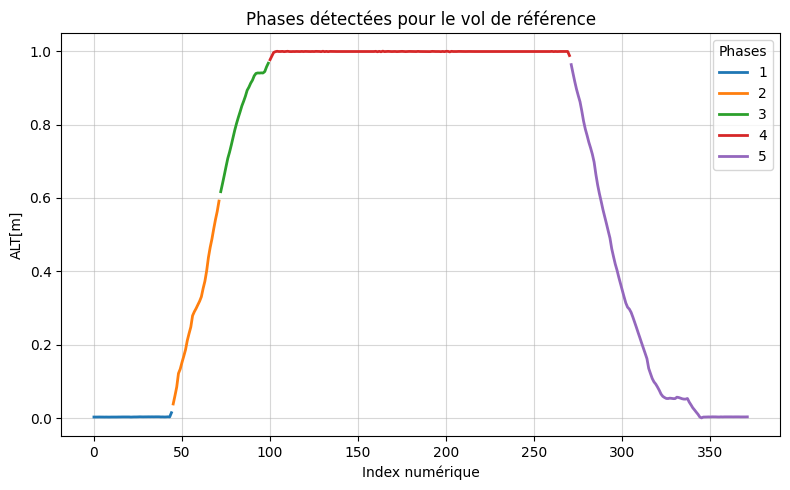

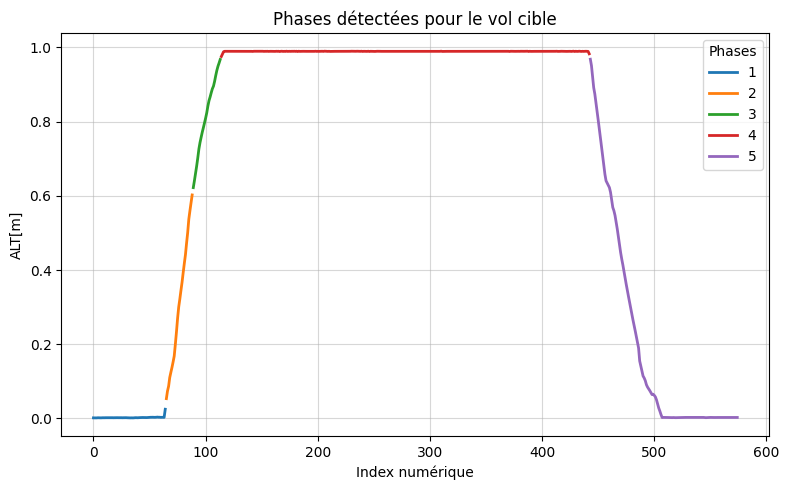

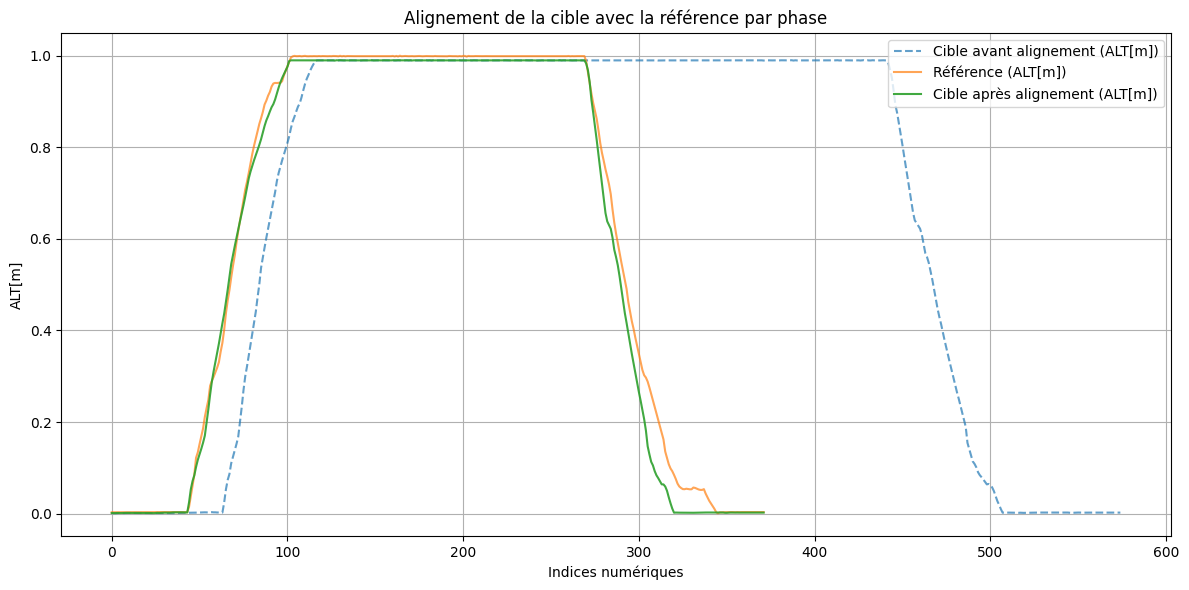

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from scipy.ndimage import gaussian_filter1d

# Fonction 1 : Prétraiter les données
def preprocess_data(data, subset_fraction=0.05, sigma=2):
    """
    Prétraite les données : sous-échantillonnage, filtrage gaussien, calcul des dérivées et extraction des colonnes.
    """
    # Sous-échantillonnage
    data = data.iloc[::int(1 / subset_fraction), :]

    # Filtrage gaussien pour réduire le bruit
    alt = gaussian_filter1d(data["ALT[m]"].values, sigma=sigma)
    vz = gaussian_filter1d(data["Vz[m/s]"].values, sigma=sigma)
    tas = gaussian_filter1d(data["TAS[m/s]"].values, sigma=sigma)
    #tisa = gaussian_filter1d(data["Tisa[K]"].values, sigma=sigma)
    #f = gaussian_filter1d(data["F[N]"].values, sigma=sigma)

    # Calcul des dérivées
    d_alt = np.gradient(alt)
    d2_alt = np.gradient(d_alt)  # Dérivée de l'altitude
    d_vz = np.gradient(vz)    # Dérivée de la vitesse verticale
    d_tas = np.gradient(tas)  # Dérivée de la vitesse sol

    # Retourner les observations sous forme de tableau
    #observations = np.column_stack([alt, vz, tas, d_alt, d_vz, d_tas])
    observations = np.column_stack([alt, d_alt, d2_alt])

    return data, observations

# Fonction 2 : Créer et entraîner un modèle HMM
def create_hmm_model(n_states, random_state=42):
    """
    Crée un modèle HMM avec une matrice de transition contrainte.
    """
    model = GaussianHMM(
        n_components=n_states,
        covariance_type="diag",
        n_iter=1000,
        tol=1e-4,
        init_params="mcs",
        random_state=random_state,
    )

    # Matrice de transition contrainte
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(n_states - 1):
        transition_matrix[i, i] = 0.7  # Rester dans la même phase
        transition_matrix[i, i + 1] = 0.3  # Passer à la phase suivante
    transition_matrix[-1, -1] = 1.0  # Phase finale : rester dans "Atterrissage"
    #transition_matrix +=1e-10
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

    model.transmat_ = transition_matrix
    return model

# Fonction 3 : Détecter les phases avec le HMM
def detect_phases(data, model, states):
    """
    Associe les phases détectées par le modèle HMM aux données.
    """
    observations = np.column_stack([
        data["ALT[m]"], 
        #data["Vz[m/s]"], 
        #data["TAS[m/s]"], 
        np.gradient(data["ALT[m]"].values),
        np.gradient(np.gradient(data["ALT[m]"].values)),
        #np.gradient(data["Vz[m/s]"].values),  # Dérivée de la vitesse verticale
        #np.gradient(data["TAS[m/s]"].values),  # Dérivée de la vitesse sol
    ])
    hidden_states = model.predict(observations)
    data["Phase"] = [states[state] for state in hidden_states]
    return data

# Charger les données
input_file = "../Data/normalized/AFL1EB_normalized.h5"
from tabata.opset import Opset
ds = Opset(input_file)

# Charger les vols de référence et cible
reference = ds[11]  # Exemple : vol de référence
target = ds[44]    # Exemple : vol cible

# Prétraiter les données
reference, ref_obs = preprocess_data(reference)
target, tgt_obs = preprocess_data(target)

# Définir les phases et le modèle HMM
states = ["0","1", "2", "3", "4", "5"]
model = create_hmm_model(n_states=len(states))

# Entraîner le modèle sur le vol cible (ou sur des données combinées si nécessaire)
model.fit(tgt_obs)

# Détecter les phases pour la référence et la cible
reference = detect_phases(reference, model, states)
target = detect_phases(target, model, states)

# Visualiser les résultats des phases détectées
def plot_phases_on_flight(data, phases_col="Phase", value_col="ALT[m]", title="Phases détectées par vol"):
    """
    Visualise les phases détectées sur un vol donné.
    """
    unique_phases = data[phases_col].unique()
    phase_colors = {phase: color for phase, color in zip(unique_phases, plt.cm.tab10.colors)}

    x_indices = np.arange(len(data))
    plt.figure(figsize=(8, 5))
    for phase in unique_phases:
        phase_mask = data[phases_col] == phase
        plt.plot(
            x_indices[phase_mask],
            data.loc[phase_mask, value_col],
            label=phase,
            color=phase_colors[phase],
            linewidth=2,
        )

    plt.xlabel("Index numérique")
    plt.ylabel(value_col)
    plt.title(title)
    plt.legend(title="Phases", loc="best")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_phases_on_flight(reference, "Phase", "ALT[m]", "Phases détectées pour le vol de référence")
plot_phases_on_flight(target, "Phase", "ALT[m]", "Phases détectées pour le vol cible")

aligned_data = align_by_phase(reference, target, states)

plot_alignment(reference, target, aligned_data)
